# Blueing Reflectivity Integration (BRI) Technique for Seismic Spectral Enhancement
# Application in Jupyter Notebook and GUI in Python

In [1]:
"""
Blueing Reflectivity Integration (BRI) Technique for Seismic Spectral Enhancement
Author: Amir Abbas Babasafari (AB) 
Date: October 2023 
Email: a.babasafari@yahoo.com
"""

'\nBlueing Reflectivity Integration (BRI) Technique for Seismic Spectral Enhancement\nAuthor: Amir Abbas Babasafari (AB) \nDate: October 2023 \nEmail: a.babasafari@yahoo.com\n'

## Import Libraries

In [2]:
# Import Libraries
import os
import sys
# import global
import numpy as np
# import pandas as pd
import segyio 
from scipy.linalg import toeplitz
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
from tkinter import *
from tkinter import filedialog

## Load a segy file 

In [3]:
def load_segy_file():
    '''
    Function to load a segy file
    
    Return file path of loaded segy file
    '''
    
    global filepath
    
    # Open file name
    file = filedialog.askopenfilename(initialdir = os.getcwd(),
    title = "Please select 2D/3D post-stack seismic data in segy format",
    filetypes = [('sgy files','*.sgy'),('segy files','*.segy'),('All files','*.*')])
    filepath = file
    print(filepath)
    
# Create root window
root = Tk()
root.geometry('300x200')  
root.title('BRI')

# Open button to click in a GUI toolkit
open_button1 = Button(root, text = "Open a File", command = load_segy_file)
open_button2 = Button(root, text = "Close the Window", command = root.destroy)
open_button1.pack()
open_button2.pack()

# Run the application
root.mainloop()

E:/AB_2023/BRI/segy_test/Seismic_open_data/3D-Waipuku.sgy


## Define data as 2D or 3D and Post-Stack or Pre-Stack as well as selecting data for display

In [4]:
def define_data_dimension_stack_display(filepath_in):    
    """   
    Function to define data type as 2D or 3D and Post-Stack or Pre-Stack as well as selecting data for display 
    
    Parameter:
    ----------
    filepath_in (str): file path of loaded segy file
    
    Returns:
    --------
    data_display (numpy.ndarray): Seismic amplitude traces to plot
    If data is 2D (arbitrary line, single inline, or single crossline), all traces are displayed
    If data is 3D, traces of middle inline are displayed, however BRI is applied to the entire traces of 3D volume

    data_type (str): Define data as 2D or 3D and Post-Stack or Pre-Stack
    
    seismic_data_shape (tuple): Shape of loaded seismic data
    
    cdp_no (numpy.ndarray): array of CDP number for seismic data to display
    
    """
    print(filepath_in)
    # Supported inline and crossline byte locations
    inline_xline = [[189,193], [9,21], [5,21]]
    
    # Read segy data with the specified byte location of geometry 
    for byte_loc in inline_xline:

        try:
            with segyio.open(filepath_in, iline = byte_loc[0], xline = byte_loc[1], ignore_geometry=False) as f:
                seismic_data = segyio.tools.cube(f)
                n_traces = f.tracecount    
                # tr = f.bin[segyio.BinField.Traces]
                tr = f.attributes(segyio.TraceField.TraceNumber)[-1]
                if not isinstance(tr, int):
                    tr = f.attributes(segyio.TraceField.TraceNumber)[-2] + 1
                tr = int(tr[0])
                spec = segyio.spec()
                spec.sorting = f.sorting
                data_sorting = spec.sorting == segyio.TraceSortingFormat.INLINE_SORTING

        except:
            pass

    # Define sort of data    
    try:
        if data_sorting is True:
            print('Data is sorted by Inline')
        else:
            print('Data is sorted by Crossline')

    except:
        print('Error, Please check inline and crossline byte locations')
        raise  

        
    # Define data as 2D/3D and Post-stack/Pre-stack
    if len(seismic_data.shape) == 3:
        if seismic_data.shape[0] != 1:
            data_type = 'Post-stack 3D'
        else:
            if n_traces > tr > 1:   
                data_type = 'Post-stack 3D'
            else:
                data_type = 'Post-stack 2D'
            
    else:        
        if len(f.offsets) > 1:
            if seismic_data.shape[0] == 1:
                data_type = 'Pre-Stack 2D'
            else:
                data_type = 'Pre-Stack 3D'    
        else:
            print('Error, Please check inline and crossline byte locations')
       
    print('Data Type: {0}'.format(data_type))
    print('Seismic Data Shape: {0}'.format(seismic_data.shape))
    
    #  The application supports post-stack data
    if data_type == 'Post-stack 2D' or data_type == 'Post-stack 3D':
        pass
    else:
        print('Please make sure that data loaded is 2D or 3D post-stack seismic data, pre-stack is not supported') 
    
    
    # Specify data for display and CDP range based on type of data    
    inline, cdp, samples = seismic_data.shape
    
    if data_type == 'Post-stack 2D':
        data_display = seismic_data.reshape(cdp, samples).T
        cdp_no = np.arange(n_traces)    
    
    elif data_type == 'Post-stack 3D':
        if inline == 1 and tr > 1 and n_traces % tr == 0:  
            inline_no =  n_traces / tr
            inline_mid = int(inline_no / 2)
            cdp_range = np.arange(inline_mid * tr, inline_mid * tr + tr)
            data_display = seismic_data.reshape(cdp, samples).T
            data_display = data_display[:, cdp_range]
            cdp_no = np.arange(tr)
            print('Seismic Data Shape after reshape: {0}'.format((int(inline_no), int(tr), int(samples))))

        else:  
            inline_mid = int(inline / 2)
            data_display = seismic_data[inline_mid, :, :].T
            cdp_no = np.arange(cdp)
            
    return data_display, data_type, seismic_data.shape, cdp_no

data_display, data_type, seismic_data_shape, cdp_no = define_data_dimension_stack_display(filepath)

E:/AB_2023/BRI/segy_test/Seismic_open_data/3D-Waipuku.sgy
Data is sorted by Inline
Data Type: Post-stack 3D
Seismic Data Shape: (1, 46176, 2001)
Seismic Data Shape after reshape: (148, 312, 2001)


## Read 2D/3D post-stack seismic data (segy file) and specify data-related parameters

In [5]:
def read_seismic_segy(filepath_in):
    """   
    Function to read 2D/3D post-stack seismic data (segy file) and specify data-related parameters
    
    Parameter:
    ----------
    filepath_in (str): file path of loaded segy file
    Note: Segy data should be in time domain and post-stack seismic data
    
    Returns:
    --------
    data (numpy.ndarray): All seismic amplitude traces in 2D array
    
    n_traces (int): Number of traces
    
    sample_rate (float): Sample rate of seismic data in ms
    
    twt (numpy.ndarray): array of TWT number
    
    """
    
    # Read segy data and specify data parameters
    try:
        with segyio.open(filepath_in, ignore_geometry=True) as f:
            # Get the attributes
            n_traces = f.tracecount
            sample_rate = segyio.tools.dt(f) / 1000
            n_samples = f.samples.size
            twt = f.samples
            data = f.trace.raw[:].T 
            spec = segyio.spec()
            data_format = f.format
            
            # print(f.bin)
            print('No. Traces: {0}, No. Samples: {1}, Sample_rate: {2}ms, Trace_length: {3}ms, Format: {4}'
                  .format(n_traces, n_samples, sample_rate, max(twt) - min(twt), data_format))

            return data, n_traces, sample_rate, twt, data_format
    except:
        print('Please make sure that inline and crossline byte locations are correct')
        print('In addition, please check that data loaded is 2D or 3D post-stack seismic data, pre-stack is not supported')
        raise
        
data, n_traces, sample_rate, twt, data_format = read_seismic_segy(filepath)

No. Traces: 46176, No. Samples: 2001, Sample_rate: 2.0ms, Trace_length: 4000.0ms, Format: 4-byte IBM float


## Extracting header information of segy file (Geometry-related byte locations)

In [6]:
def read_segy_byte_locations(filepath_in):  
    """   
    Function to extract header information of segy file (Geometry-related byte locations) 
    
    Parameter:
    ----------
    filepath_in (str): file path of loaded segy file
    Note: Segy data should be in time domain and post-stack seismic data
    
    Returns:
    --------
    TraceSequenceFile, Field_Record, CDP, Source_X, Source_Y, CDP_X, CDP_Y, Inline_3D, and Crossline_3D (list): 
    Geometry-related byte locations
    """
    
    # Extract standard geometry-related byte locations from segy header  
    with segyio.open(filepath_in, ignore_geometry=True) as f:
        
        # Get the Geometry-related attributes
        n_traces = f.tracecount

        # Initialize value
        # TRACE_SEQUENCE_FILE _ byte location:5
        TraceSequenceFile = []
        # FieldRecord _ byte location:9
        Field_Record = []
        # Trace_Field _ byte location:13
        Trace_Field = []
        # CDP _ byte location:21
        CDP = []
        # Trace_Number _ byte location:25
        Trace_Number = []
        # SourceX _ byte location:73
        # Scaler_coordinate _ byte location:71
        Scaler_coordinate = []
        Source_X = []
        # SourceY _ byte location:77
        Source_Y = []
        # CDP_X _ byte location:181
        CDP_X = []
        # CDP_Y _ byte location:185
        CDP_Y = []
        # INLINE_3D _ byte location:189
        Inline_3D = []
        # CROSSLINE_3D _ byte location:193
        Crossline_3D = []

        for i in range(n_traces):
            trace_no = f.attributes(segyio.TraceField.TRACE_SEQUENCE_FILE)[i]; TraceSequenceFile.append(trace_no)
            field_record = f.attributes(segyio.TraceField.FieldRecord)[i]; Field_Record.append(field_record)
            trace_field = f.attributes(segyio.TraceField.TraceNumber)[i]; Trace_Field.append(trace_field)
            cdp = f.attributes(segyio.TraceField.CDP)[i]; CDP.append(cdp)
            cdp_tr_no = f.attributes(segyio.TraceField.CDP_TRACE)[i]; Trace_Number.append(cdp_tr_no)
            scale = f.attributes(segyio.TraceField.SourceGroupScalar)[i]; Scaler_coordinate.append(scale)
            gx = f.attributes(segyio.TraceField.SourceX)[i]; Source_X.append(gx)
            gy = f.attributes(segyio.TraceField.SourceY)[i]; Source_Y.append(gy)
            cdp_x = f.attributes(segyio.TraceField.CDP_X)[i]; CDP_X.append(cdp_x)
            cdp_y = f.attributes(segyio.TraceField.CDP_Y)[i]; CDP_Y.append(cdp_y)
            inline = f.attributes(segyio.TraceField.INLINE_3D)[i]; Inline_3D.append(inline)
            xline = f.attributes(segyio.TraceField.CROSSLINE_3D)[i]; Crossline_3D.append(xline)
    
    return TraceSequenceFile, Field_Record, Trace_Field, CDP, Trace_Number, Scaler_coordinate, Source_X, Source_Y, CDP_X, CDP_Y, Inline_3D, Crossline_3D

TraceSequenceFile, Field_Record, Trace_Field, CDP, Trace_Number, Scaler_coordinate, Source_X, Source_Y, CDP_X, CDP_Y, Inline_3D, Crossline_3D = read_segy_byte_locations(filepath)

## Scatter-plotting of X and Y Geometry

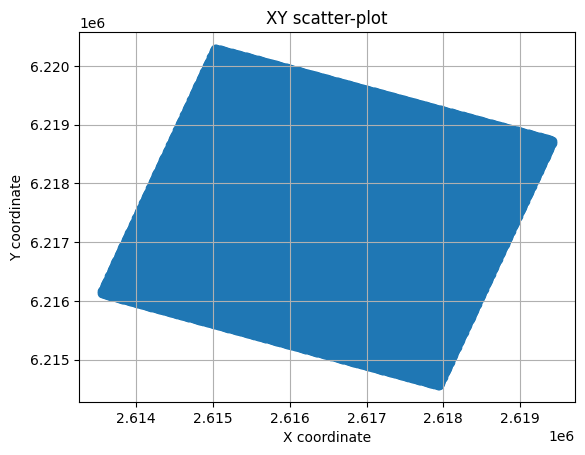

In [7]:
def xy_plot(Source_X, Source_Y, CDP_X, CDP_Y):
    """   
    Function for scatter-plotting of X and Y Geometry
    
    Parameter:
    ----------
    Source_X, Source_Y, CDP_X, and CDP_Y (list): 
    Geometry-related byte locations
    
    Returns:
    --------
    Scatter-plot of X and Y Coordinates    
    """

    if np.any(Scaler_coordinate) != 0:
        Scaler = np.asarray([np.abs(1/x) for x in Scaler_coordinate], dtype = float)
        Source_X_plot = Source_X * Scaler
        Source_Y_plot = Source_Y * Scaler
        CDP_X_plot = CDP_X * Scaler
        CDP_Y_plot = CDP_Y * Scaler
    else:
        Source_X_plot = Source_X
        Source_Y_plot = Source_Y
        CDP_X_plot = CDP_X
        CDP_Y_plot = CDP_Y

    # Plot data X and Y based on the standard byte locations (73,77) or (181,185)
    if np.any(Source_X_plot) != 0:
        plt.scatter(Source_X_plot, Source_Y_plot)
    else:
        plt.scatter(CDP_X_plot, CDP_Y_plot)
    
    # set the axis lables
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.title("XY scatter-plot")
    plt.grid(True)
    plt.show()
    
xy_plot(Source_X, Source_Y, CDP_X, CDP_Y)

## Display seismic data (segy file)

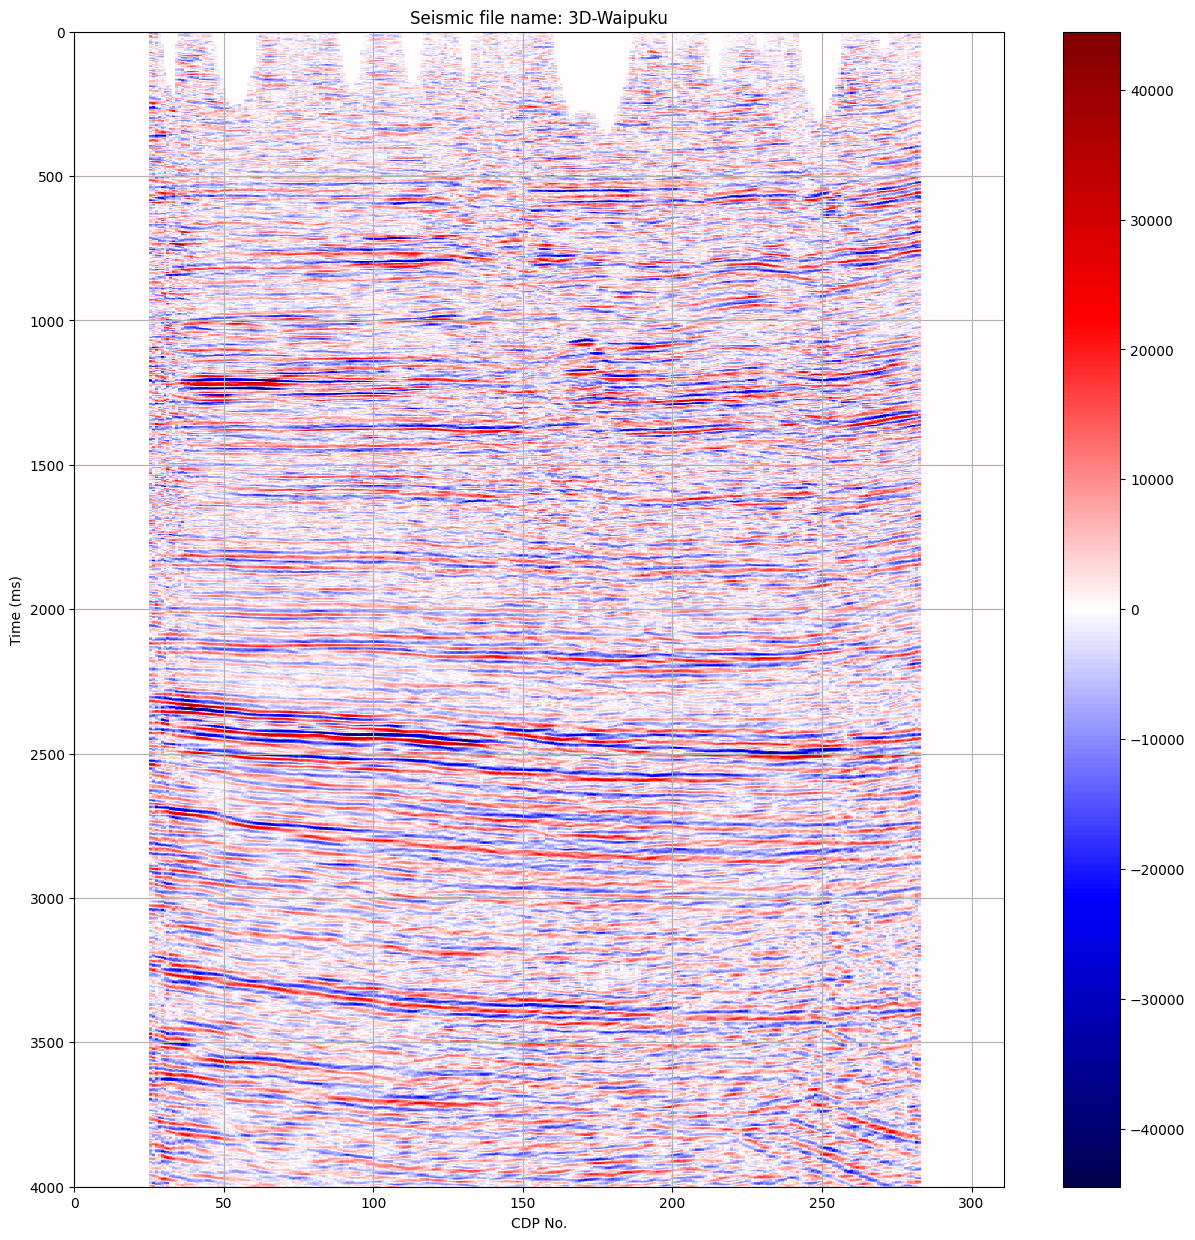

In [8]:
def display_seismic_data(filepath_in, seismic_data, cdp_no, twt):    
    """   
    Function to display seismic data (segy file)
    
    Parameter:
    ----------
    seismic_data (numpy.ndarray): seismic amplitude traces selected to display
    
    cdp_no (numpy.ndarray): array of CDP number for seismic data to display

    twt (numpy.ndarray): array of TWT number
    
    Returns:
    --------
    Plot seismic traces        
    """
   
    # Plot seismic data 2D (entire line) and 3D (the mid inline number)
    plt.figure(figsize=(15,15))
    plt.imshow(seismic_data, interpolation = 'nearest', cmap = plt.cm.seismic, aspect = 'auto', 
               vmin = -np.max(seismic_data), vmax = np.max(seismic_data), extent = (min(cdp_no), max(cdp_no), max(twt), min(twt)))
    # plt.colorbar(anchor=(0, 0.3), shrink=0.7)
    plt.xlabel("CDP No.")
    plt.ylabel("Time (ms)")
    plt.title("Seismic file name: {0}".format(os.path.splitext(os.path.basename(filepath_in))[0]))
    plt.grid(True)
    plt.colorbar()
    plt.show()
    
display_seismic_data(filepath, data_display, cdp_no, twt)

## Plot amplitude spectrum

In [9]:
def calculate_amplitude_spectrum(seismic_data, sample_rate, mode = 'seismic amplitude'):    
    
    """   
    Function to calculate amplitude spectrum
    
    Parameter:
    ----------
    seismic_data (numpy.ndarray): All seismic amplitude traces in 2D array
    sample_rate (float): Sample rate of seismic data in ms
    mode (str): 'seismic amplitude' , 'rc amplitude'

    Returns:
    --------
    amplitude_spectrum (numpy.ndarray): Amplitude spectrum of selected traces
    frequency_axis_interpolated (numpy.ndarray): Interpolated frequency axis
    nyquist_frequency (int): Nyquist frequency (HZ)
    
    """

    if mode == 'seismic amplitude':
        # Select a weight for skipping traces on a coarse grid
        coef = 0.1
        # Select every n trace for averaging the amplitude spectrum
        n = int(seismic_data.shape[1] * coef)

        if seismic_data.shape[1] > 1: 
            traces = seismic_data[:,::n]
        else:
            traces = seismic_data
    
    elif mode == 'rc amplitude':
        traces = seismic_data
        
    # Define sample rate and nyquist frequency
    sample_rate = sample_rate * 1e-3
    nyquist_frequency = int(1 / (2 * sample_rate))
    
    # Initialize amplitude based on nyquist frequency
    amplitude_spectrum = np.empty(shape=(nyquist_frequency, traces.shape[1]))

    # Calculate amplitude spectrum using fourier transform
    for i in range(traces.shape[1]):
        
        n_sample = len(traces[:,i])
        spectrum = np.fft.fft(traces[:,i] / n_sample)
        frequency = np.fft.fftfreq(n_sample)
        
        # Display positive frequency content with corresponding absolute and real amplitude
        spectrum_real = abs(spectrum[:int(n_sample / 2)].real)
        # scale frequency axis wih Nyquist frequency for positive axis only
        frequency_axis = frequency[:int(n_sample / 2)] * (1 / sample_rate)

        # Interpolate spectrum_real and freq_axis
        frequency_axis_interpolated = np.arange(0,nyquist_frequency, 1)
        spectrum_real_interpolated = np.interp(frequency_axis_interpolated, frequency_axis, spectrum_real)
        amplitude_spectrum[:,i] = spectrum_real_interpolated

    return amplitude_spectrum, frequency_axis_interpolated, nyquist_frequency
    
amplitude_spectrum_seismic, frequency_axis_interpolated, nyquist_frequency = calculate_amplitude_spectrum(data, sample_rate, mode = 'seismic amplitude')

In [10]:
def mean_amplitude_spectrum(spectrum, frequency_axis, kernel_length = 1):
    
    """   
    Function to calculate mean amplitude spectrum
    
    Parameter:
    ----------
    spectrum (numpy.ndarray): Amplitude spectrum of selected traces
    frequency_axis (numpy.ndarray): Interpolated frequency axis
    kernel_length (int): Smoothing factor

    Returns:
    --------
    mean_spectrum_normalized (numpy.ndarray): Normalized average amplitude spectrum 
    
    """

        
    # Calculate average of amplitude spectrum for all selected traces
    mean_spectrum = np.mean(spectrum, axis=1) 
    
    # Smooth the average amplitude spectrum if needed
    kernel = np.ones(kernel_length) / kernel_length
    smooth_mean_spectrum = np.convolve(mean_spectrum, kernel, mode='same')
    
    # Normalize the average amplitude spectrum 
    mean_spectrum_normalized = (smooth_mean_spectrum-min(smooth_mean_spectrum))\
    /(max(smooth_mean_spectrum)-min(smooth_mean_spectrum))
    
    return mean_spectrum_normalized
    
mean_spectrum_normalized = mean_amplitude_spectrum(amplitude_spectrum_seismic, frequency_axis_interpolated, kernel_length = 1)   


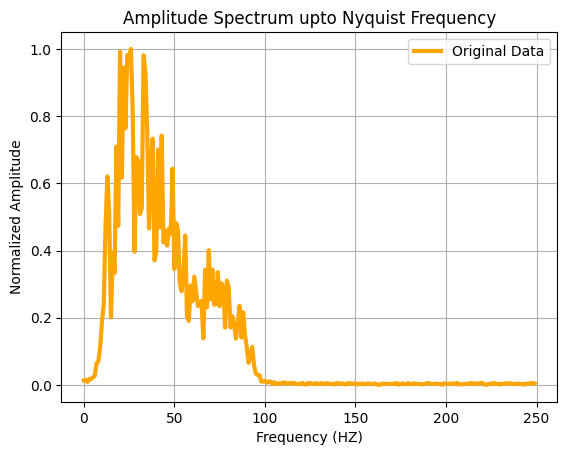

In [11]:
def plot_amplitude_spectrum(normalized_spectrum, frequency_axis, normalized_spectrum_BRI = None):
    
    """   
    Function to plot amplitude spectrum
    
    Parameter:
    ----------
    normalized_spectrum (numpy.ndarray): Normalized average amplitude spectrum 
    frequency_axis (numpy.ndarray): Interpolated frequency axis
    normalized_spectrum_BRI (numpy.ndarray): Normalized average amplitude spectrum BRI data

    Returns:
    --------
    Plot normalized amplitude spectrum      
    
    """

    # Plot the smooth average amplitude spectrum 
    plt.plot(frequency_axis, normalized_spectrum, color='orange', \
             label = 'Original Data', linestyle='solid', linewidth = 3)
    
    if not normalized_spectrum_BRI is None:
       plt.plot(frequency_axis, normalized_spectrum_BRI, color='blue', \
             label = 'BRI Data', linestyle='solid', linewidth = 3) 
    plt.xlabel('Frequency (HZ)')
    plt.ylabel('Normalized Amplitude')
    plt.title('Amplitude Spectrum upto Nyquist Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_amplitude_spectrum(mean_spectrum_normalized, frequency_axis_interpolated)    

## Calculate Pseudo Reflection Coefficient (RC) from seismic data

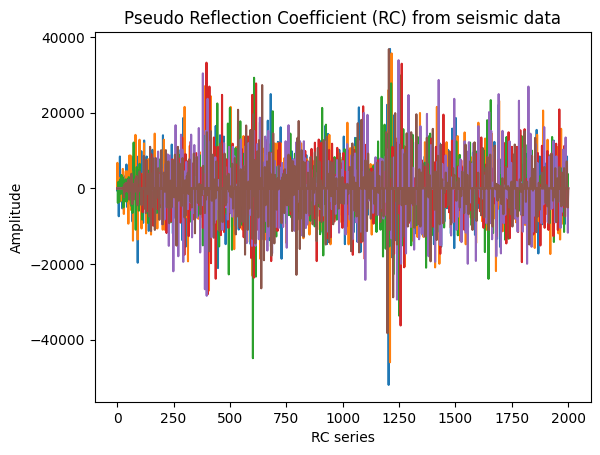

In [12]:
def get_rc_from_seismic(seismic_data, plot = True):
    
    """   
    Function to calculate pseudo Reflection Coefficient (RC) from seismic data
    
    'find min and max local minima along seismic traces by calculating zero amplitude of first derivative'
    'It is considered as reflection coefficient to be replaced with rc from well log'

    Parameter:
    ----------
    seismic_data (numpy.ndarray): All seismic amplitude traces in 2D array
    
    Returns:
    --------
    rc (numpy.ndarray): Calculated pseudo reflection coefficient from seismic data
        
    """

    
    # Select a weight for skipping traces on a coarse grid
    coef = 0.1
    # Select every n trace for averaging the amplitude spectrum
    n = int(seismic_data.shape[1] * coef)

    if seismic_data.shape[1] > 1: 
        traces = seismic_data[:,::n]
    else:
        traces = seismic_data

    # Initialize list of zero trace index    
    zero_trace_index = [] 
    
    # Calculate zero trace index and exclude zero traces from seismic data
    for ind in range(traces.shape[1]):
        if np.any(traces[:,ind]) == 0.0 or np.any(traces[:,ind]) == None:
            zero_trace_index.append(ind)
    traces = np.delete(traces, zero_trace_index, 1)
    # Initialize reflection coefficient 
    rc = np.zeros((traces.shape[0], traces.shape[1]))
    
    # Calculate reflection coefficient of selected traces
    for i in range(traces.shape[1]):
        n_sample = len(traces[:, i])
        sgn = np.sign(np.diff(traces[:, i]))
        for j in range(n_sample-2):
            if sgn[j] != sgn[j+1]:
                rc[j+1, i] = traces[j+1, i]
    
    if plot:
        plt.plot(rc)
        plt.xlabel("RC series")
        plt.ylabel("Amplitude")
        plt.title("Pseudo Reflection Coefficient (RC) from seismic data")
        plt.show()
    
    return rc

rc_series = get_rc_from_seismic(data, plot = True)
amplitude_spectrum_rc, _, _ = calculate_amplitude_spectrum(rc_series, sample_rate, mode = 'rc amplitude')


## Calculate Pseudo Reflection Coefficient (RC) from well log

In [13]:
# def get_rc_from_well_log(filepath):
    
#     """
#     Function to calculate Pseudo Reflection Coefficient (RC) from well log

#     If the acoustic impedance (AI) log (density * P-velocity ) is available, 
#     amplitude spectrum of RC log can be calculated directly from AI log.
#     RC calculated from well log produces higher resolution in final BRI output than RC calculated from seismic data.
    
    
#     Parameter:
#     ----------
#     filepath (str): file path of loaded AI file
    
#     Returns:
#     --------
#     RC (numpy.ndarray): Calculated reflection coefficient from AI log
        
#     """

#     # Load acoustic impedance log (AI) assuming there is no header to skip.
#     # Time and AI columns are first and second columns respectively.
    
#     log = np.loadtxt(filepath, skiprows=0, usecols=[0,1], converters=None)
#     AI = log[:,1]
#     n = len(AI)
    
#     # Calculate RC from AI log
#     def conv_matrx(c,n):
#         col = np.hstack([c[0], np.zeros(n-1)])
#         row = np.hstack([c, np.zeros(n-1)])
#         return toeplitz(col, row)
    
#     D = conv_matrx([-1, 1], n)    
#     RC = D[:,:-1].dot(np.log(AI))    
#     RC = RC.reshape(len(RC),1)    
#     RC = RC[1:-1]
    
#     return RC

# filepath_AI_log = "E:\AB_2023\BRI\AI_time1ms.txt"
# RC = get_rc_from_well_log(filepath_AI_log)
# amplitude_spectrum_rc, _, _ = calculate_amplitude_spectrum(RC, sample_rate, mode = 'rc amplitude')


## Find F4 Index

In [14]:
def find_f4_index(spectrum, nyquist_frequency):
    
    
    """   
    Function to compute F4 Index
    
    Find index of min spectrum_real_interp in the second half of array 
    Assuming f1, f2, f3, and f4 as low-cut, low-pass, high-pass,
    and high-cut parameters for a trapezoid shape band-pass filter (ormsby)

    Parameter:
    ----------
    spectrum (numpy.ndarray): Normalized average amplitude spectrum 
    nyquist_frequency (int): Nyquist frequency (HZ)
    
    Returns:
    --------
    f4_ind (numpy.int64): Computed f4 index 
        
    """

    # select a treshold for f4 and calculate f4 index over amplitude spectrum
    try:
        f4 = 0.05
        min_amplitude_ind = np.argwhere(f4 * max(spectrum) >= spectrum)
        max_amplitude_ind = np.argwhere(max(spectrum) == spectrum)
        f4_ind = min_amplitude_ind[min_amplitude_ind > max_amplitude_ind][0]
    except:
        f4_ind = int(nyquist_frequency/2)
        
    return f4_ind

f4_ind = find_f4_index(mean_spectrum_normalized, nyquist_frequency)
f4_ind

95

## Fitting a curve on RC amplitude spectrum

[0.6646109478997727, 2.33594882380053]


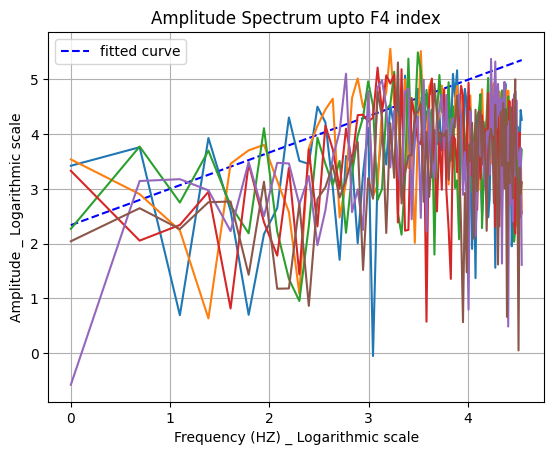

In [15]:

def fit_curve_rc_spectrum(rc_spectrum, seismic_spectrum, frequency_axis, f4_ind, method = 'calc intrcpt_grdnt', plot = True):
        
    """   
    Function for fitting a curve on RC amplitude spectrum
    
    Three functions are available for calculating the fitted curve.
    In the first method (calc intrcpt_grdnt), the gradient is calculated based on the maximum amplitude observed in 
    RC amplitude spectrum to create designed operator as if RC wel log is used. Second (linear polyfit) and Third (linear curvefit) 
    methods produce the same results. The higher gradient of fitted curve, the more amplitude is boosted.

    Parameter:
    ----------
    rc_spectrum (numpy.ndarray): Amplitude spectrum of RC traces
    seismic_spectrum (numpy.ndarray): Normalized average amplitude spectrum 
    frequency_axis (numpy.ndarray): Interpolated frequency axis
    f4_ind (numpy.int64): Computed f4 index 
    method (str): 'calc intrcpt_grdnt', 'linear polyfit', 'linear curvefit'

    Returns:
    --------
    fitted_curve (numpy.ndarray): Calculated fitted curve on RC amplitude spectrum
    
    """
        
    # Get data upto f4 index
    frequency_axis = frequency_axis[1:f4_ind]
    rc_spectrum = rc_spectrum[1:f4_ind,:]

    # Calculate a fitted curve based on intercept and gradient (recommended) 
    if method == 'calc intrcpt_grdnt':
        
        gradient_list = []
        intercept_list = []
        for i in range(rc_spectrum.shape[1]):
            intercept = np.log(rc_spectrum[0,i])
            intercept_list.append(intercept)
            gradient = (np.log(max(rc_spectrum[:,i]))-np.log(rc_spectrum[0,i]))/np.log(frequency_axis[-1]).ravel()
            gradient_list.append(gradient) 
        parameters = [np.mean(gradient_list), np.mean(intercept_list)]  

    # Calculate a fitted curve based on linear polyfit
    elif method == 'linear polyfit':
        
        fit_func_list = []
        n = 1
        for i in range(rc_spectrum.shape[1]):
            fit = np.polyfit(np.log(frequency_axis),np.log(rc_spectrum[:,i]),n)
            fit_func_list.append(fit)
        parameters = np.mean(fit_func_list, axis=0)  
    
    # Calculate a fitted curve based on curve fit function
    elif method == 'linear curvefit':
        
        def func(x, gradient, intercept):
            return gradient*x + intercept
        
        gradient_list = []
        intercept_list = []
        for i in range(rc_spectrum.shape[1]):
            x = np.log(frequency_axis)
            y = np.log(rc_spectrum[:,i])
            params, _ = curve_fit(func, x, y)
            gradient_list.append(params[0])
            intercept_list.append(params[1])
        parameters = [np.mean(gradient_list), np.mean(intercept_list)]   
                
    print(parameters)
    fitted_curve_log = np.polyval(parameters, np.log(frequency_axis))
    
    # Fitted curve upto f4 index converted back after logarithmic transformation 
    fit_curve1 = np.exp(fitted_curve_log)
    fit_curve1 = np.append(fit_curve1, fit_curve1[0])
    
    # Add amplitude spectrum from f4 index to nyquist frequency index
    fit_curve2 = seismic_spectrum[f4_ind:] * max(fit_curve1)
    fitted_curve = np.hstack((fit_curve1, fit_curve2))
    
    if plot:
        # Plot fitted curve and RC amplitude spectrum upto f4 index
        plt.plot(np.log(frequency_axis), fitted_curve_log, '--', color ='blue', label ="fitted curve")
        plt.plot(np.log(frequency_axis), np.log(rc_spectrum))
        plt.xlabel('Frequency (HZ) _ Logarithmic scale')
        plt.ylabel('Amplitude _ Logarithmic scale')
        plt.title('Amplitude Spectrum upto F4 index')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return fitted_curve

fitted_curve = fit_curve_rc_spectrum(amplitude_spectrum_rc, mean_spectrum_normalized, frequency_axis_interpolated, f4_ind, method = 'calc intrcpt_grdnt', plot = True)


## Design Operator

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


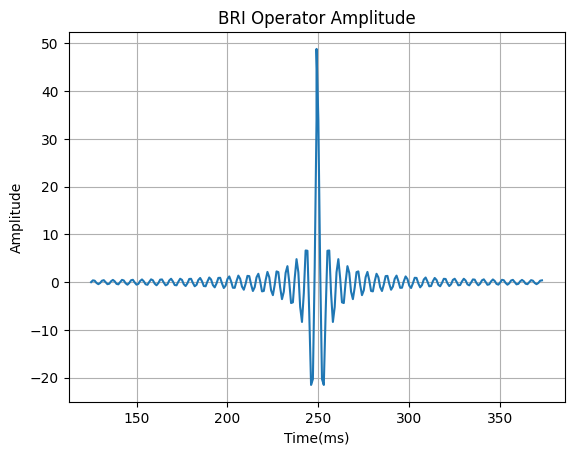

In [16]:
def bri_operator(fit_curve, frequency_axis, nyquist_frequency):
    
    """   
    Function to calculate BRI operator
    
    Parameter:
    ----------
    fit_curve (numpy.ndarray): Calculated fitted curve on RC amplitude spectrum
    frequency_axis (numpy.ndarray): Interpolated frequency axis
    nyquist_frequency (int): Nyquist frequency (HZ)

    
    Returns:
    --------
    bri_operator_amplitude (numpy.ndarray): BRI designed operator
    operator_time_axis (numpy.ndarray): Time axis of designed operator
        
    """

    # Flip amplitude spectrum and add it to the original amplitude spectrum
    operator_time_axis = np.concatenate((frequency_axis, frequency_axis + frequency_axis[-1]))
    operator_amplitude_spectrum = np.concatenate((fit_curve, fit_curve[::-1]))
    
    # Implement inverse fft 
    operator_amplitude_time = np.fft.ifft(operator_amplitude_spectrum)
    
    # Take fftshift to compute the designed operator
    bri_operator_amplitude = np.fft.fftshift(operator_amplitude_time)
    
    # Limit time axis for display
    a = int(nyquist_frequency - nyquist_frequency/2)
    b = int(nyquist_frequency + nyquist_frequency/2)
    
    # Plot designed operator
    plt.plot(operator_time_axis[a:b], bri_operator_amplitude[a:b])
    plt.xlabel('Time(ms)')
    plt.ylabel('Amplitude')
    plt.title('BRI Operator Amplitude')
    plt.grid(True)
    plt.show()
    
    return bri_operator_amplitude, operator_time_axis

bri_operator_amplitude, operator_time_axis = bri_operator(fitted_curve, frequency_axis_interpolated, nyquist_frequency)

## BRI seismic data

In [17]:
def convolve_seismic_operator(seismic_data, operator_amplitude, operator_time):

    """   
    Function to convolve seismic traces and BRI operator
    
    Parameter:
    ----------
    seismic_data (numpy.ndarray): All seismic amplitude traces in 2D array
    operator_amplitude (numpy.ndarray): BRI designed operator
    operator_time (numpy.ndarray): Time axis of designed operator

    
    Returns:
    --------
    bri_data (numpy.ndarray): BRI seismic data based on Blueing Reflectivity Integration Technique  
    
    """

    # Initialize BRI output
    bri_data = np.empty((seismic_data.shape[0], seismic_data.shape[1]))
    
    # Convolve the designed operator to the seismic data to produce final BRI output
    for i in range(seismic_data.shape[1]):
        
        if np.any(seismic_data[:,i]) != 0.0: 
            
            if len(operator_amplitude) > len(seismic_data[:, i]):
                index = int((len(operator_amplitude) - len(seismic_data[:, i]))/2)
                bri_temp = np.convolve(operator_amplitude[index:-index] / len(operator_time[index:-index]), seismic_data[:, i],'same').real
                try:
                    bri = bri_temp[1:] 
                    # Normalize the BRI trace's amplitude with seismic trace amplitude
                    bri_data[:, i] = bri * (max(seismic_data[:,i]) / max(bri))
                except:
                    bri = bri_temp
                    bri = np.delete(bri, 0)
                    bri = np.append(bri, bri[-1]) 
                    # Normalize the BRI trace's amplitude with seismic trace amplitude
                    bri_data[:, i] = bri * (max(seismic_data[:,i]) / max(bri))
            
            else:
                bri = np.convolve(operator_amplitude / len(operator_time), seismic_data[:, i], 'same').real
                bri = np.delete(bri,0)
                bri = np.append(bri,bri[-1])  
                # Normalize the BRI trace's amplitude with seismic trace amplitude
                bri_data[:,i] = bri * (max(seismic_data[:,i]) / max(bri))
        
        else: 
            bri_data[:,i] = seismic_data[:,i]
            
    return bri_data
            
BRI_data = convolve_seismic_operator(data, bri_operator_amplitude, operator_time_axis)

## Display BRI seismic data 

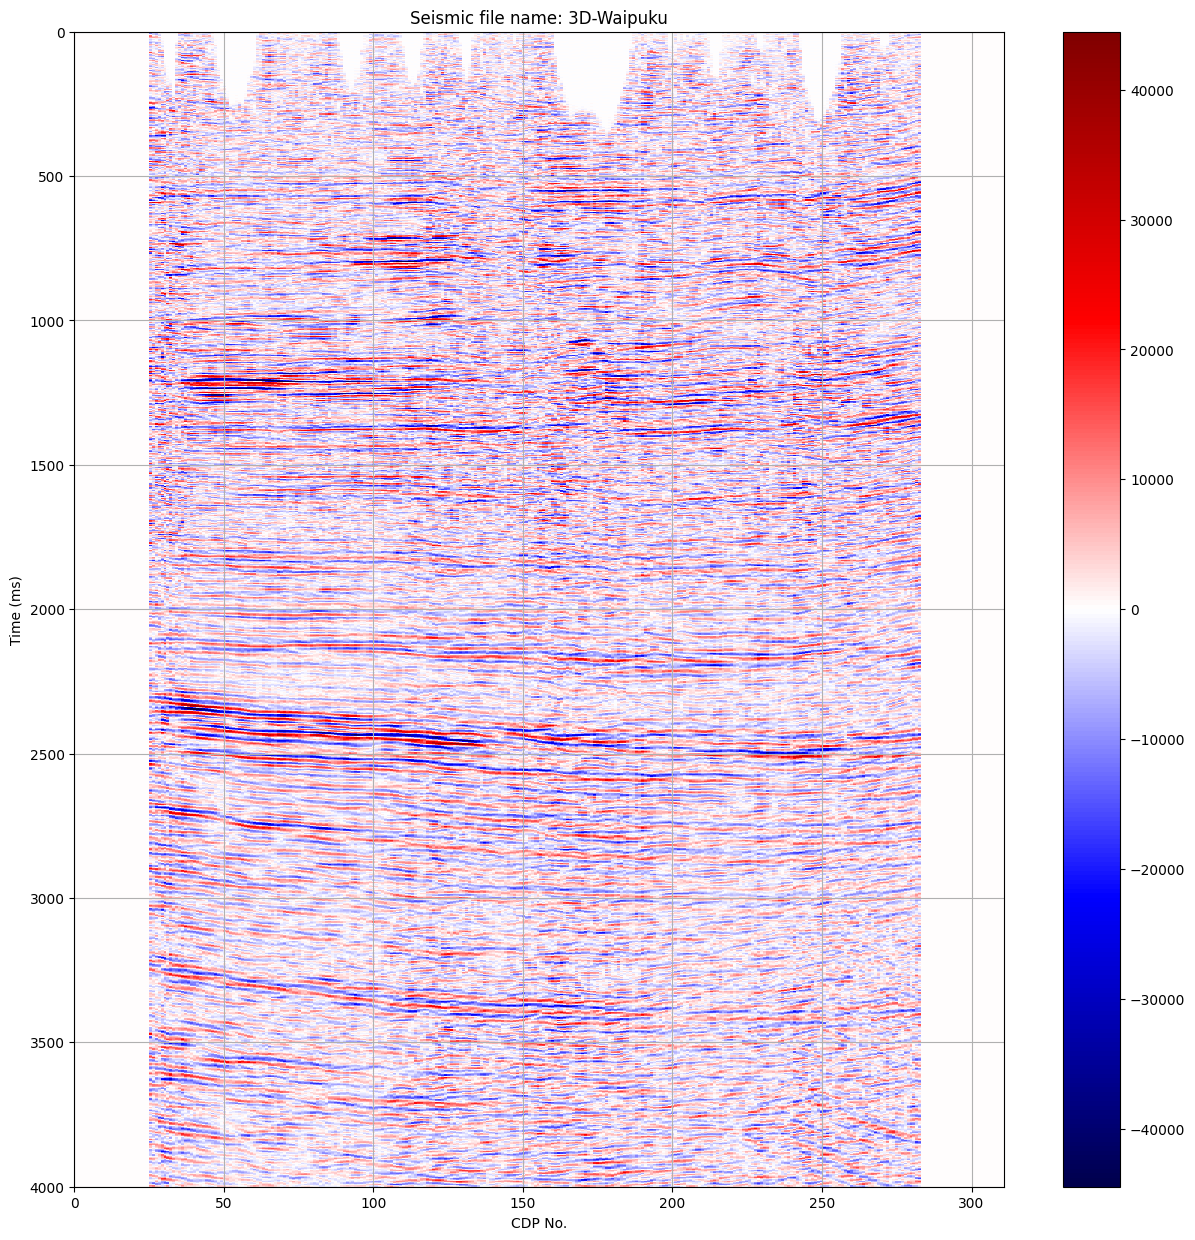

In [18]:
bri_data_display = convolve_seismic_operator(data_display, bri_operator_amplitude, operator_time_axis)
display_seismic_data(filepath, bri_data_display, cdp_no, twt)


## QC at one CDP

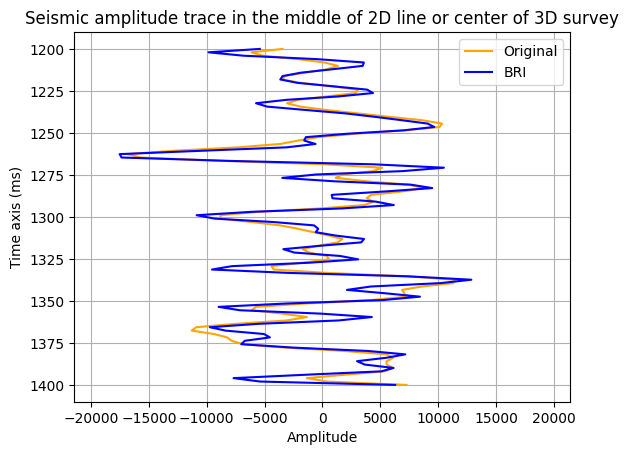

In [19]:
def compare_input_output_1d(data_display, bri_data_display, start_time, end_time, trace_no):
    
    """   
    Function to compare seismic and BRI data at one location
    A simple overlay comparison between original seismic and BRI at selected location
    Start_time and end_time are in ms

    Parameter:
    ----------
    data_display (numpy.ndarray): Original seismic amplitude traces for display
    bri_data_display (numpy.ndarray): BRI seismic amplitude traces for display
    start_time (numpy.float64): Selected starting time; Default is time of first sample
    end_time (numpy.float64): Selected ending time; Default is time of last sample
    trace_no (int): Selected trace number; Default is trace in the middle of 2D line or center of 3D survey

    Returns:
    --------
    Plot selected seismic amplitude traces (Original and BRI)
    """

    try:
        start_index = int((start_time - twt[0]) / sample_rate)
        end_index = int((end_time - twt[0]) / sample_rate)
        Time_axis = np.linspace(start_time, end_time, end_index - start_index)

        plt.plot(data_display[start_index:end_index, trace_no], Time_axis, label='Original', color = 'orange')
        plt.plot(bri_data_display[start_index:end_index, trace_no], Time_axis, label='BRI', color = 'blue')
        plt.gca().invert_yaxis()
        plt.xlim([-max(data_display[:, trace_no]), max(data_display[:, trace_no])])
        plt.xlabel('Amplitude')
        plt.ylabel('Time axis (ms)')
        plt.title('Seismic amplitude trace in the middle of 2D line or center of 3D survey')
        plt.grid(True)
        plt.legend()
    
    except:
        print('Please make sure start_time and end_time are selected from {0} to {1} ms, also trace_no is between {2} and {3}'
             .format(twt[0], twt[-1], cdp_no[0], cdp_no[-1]))
        
compare_input_output_1d(data_display, bri_data_display, 1200, 1400, int(np.median(cdp_no)))


## Overlay comparison of amplitude spectrum for original and BRI seismic data

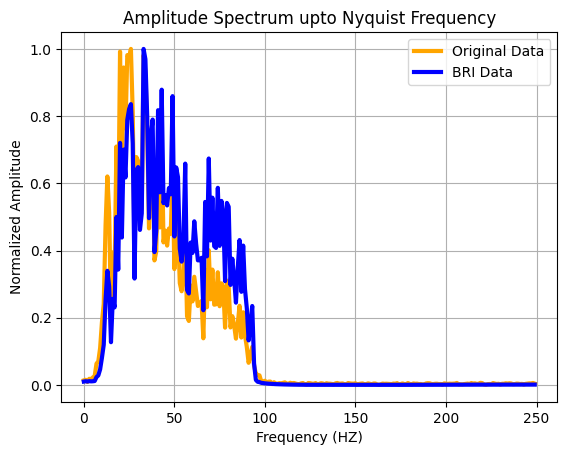

In [20]:
amplitude_spectrum_BRI, _, _ = calculate_amplitude_spectrum(BRI_data, sample_rate, mode = 'seismic amplitude')
mean_spectrum_normalized_BRI = mean_amplitude_spectrum(amplitude_spectrum_BRI, frequency_axis_interpolated, kernel_length = 1)   
plot_amplitude_spectrum(mean_spectrum_normalized, frequency_axis_interpolated, mean_spectrum_normalized_BRI)    

## Export 2D/3D post-stack BRI data (segy file) 

In [21]:
def export_seismic_segy(filepath_in, seismic_data, sample_rate, twt):
    
    """   
    Function to export 2D/3D post-stack BRI data (segy file)
    
    Parameter:
    ----------
    filepath_in (str): file path of loaded segy file
    seismic_data (numpy.ndarray): BRI seismic data 
    sample_rate (float): sample rate of seismic data in ms
    twt (numpy.ndarray): array of TWT number
    
    Returns:
    --------
    filepath_out (str): file path of export BRI segy file
    """

    # Specify output name with the same parameters of input segy 
    base_filepath = os.path.split(filepath_in)[0]
    base_filename = os.path.splitext(os.path.basename(filepath_in))[0]                
    filepath_out = base_filepath + '/' + base_filename + '_BRI.sgy'
    segyout = seismic_data.T
    segyio.tools.from_array(filepath_out, segyout, dt = sample_rate * 1e3, delrt = min(twt), format = segyio.SegySampleFormat(1))
    return filepath_out

filepath_out = export_seismic_segy(filepath, BRI_data, sample_rate, twt)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\segyio\utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


## Writing header information on segy output (Geometry-related byte locations)

In [22]:
def write_segy_byte_locations(filepath_in, filepath_out):
    
    """   
    Function for writing header information on segy output (Geometry-related byte locations)
    
    Parameter:
    ----------
    filepath_in (str): file path of loaded segy file
    filepath_out (str): file path of export BRI segy file
    
    Returns:
    --------
    Update header information and Geometry of export BRI segy file based on loaded segy file   
    """

    # Read input byte locations
    TraceSequenceFile, Field_Record, Trace_Field, CDP, Trace_Number, Scaler_coordinate, Source_X, Source_Y, CDP_X, CDP_Y, Inline_3D, Crossline_3D = read_segy_byte_locations(filepath_in)
    
    # Write the same input geometry over the output segy
    with segyio.open(filepath_out, mode='r+') as f:
        try:
            for i, val in enumerate(f.header):
                val.update({segyio.TraceField.TRACE_SEQUENCE_FILE: int(TraceSequenceFile[i].item())})
                val.update({segyio.TraceField.FieldRecord: int(Field_Record[i].item())})
                val.update({segyio.TraceField.TraceNumber: int(Trace_Field[i].item())})
                val.update({segyio.TraceField.CDP: int(CDP[i].item())})
                val.update({segyio.TraceField.CDP_TRACE: int(Trace_Number[i].item())})
                val.update({segyio.TraceField.SourceGroupScalar: int(Scaler_coordinate[i].item())})
                val.update({segyio.TraceField.SourceX: int(Source_X[i].item())})
                val.update({segyio.TraceField.SourceY: int(Source_Y[i].item())})
                val.update({segyio.TraceField.CDP_X: int(CDP_X[i].item())})
                val.update({segyio.TraceField.CDP_Y: int(CDP_Y[i].item())})
                val.update({segyio.TraceField.INLINE_3D: int(Inline_3D[i].item())})
                val.update({segyio.TraceField.CROSSLINE_3D: int(Crossline_3D[i].item())})
        except ValueError:
            print('something went wrong during header writing')
    
write_segy_byte_locations(filepath, filepath_out)        